In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, we read in the data.

In [2]:
training_df = pd.read_csv('data/training_set.csv')
training_metadata_df = pd.read_csv('data/training_set_metadata.csv')

In [3]:
obj_ids = np.unique(training_df.object_id)

/Users/neilbassett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


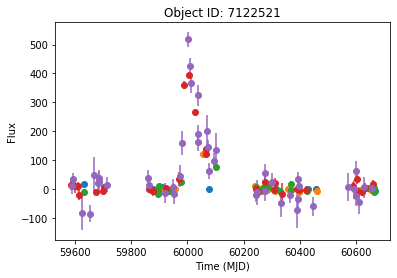

In [140]:
obj_id = np.random.choice(obj_ids)
obj = training_df[training_df.object_id == obj_id]
for passband in np.arange(1, 6):
    plt.errorbar(obj[training_df.passband == passband].mjd, obj[training_df.passband == passband].flux,\
                 yerr=obj[training_df.passband == passband].flux_err, fmt='o')
plt.xlabel('Time (MJD)')
plt.ylabel('Flux')
plt.title('Object ID: %i' % obj_id)
plt.show()

We make a list of the possible different classes. Note that the classes are labeled by somewhat random numbers, but in the report we will refer to them simply as classes 1-14.

In [4]:
targets = np.unique(training_metadata_df.target)
print(targets)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


The following cells are for calculating the weighted logarithmic loss function which we will use to evaluate both the baseline and our machine learning algorithms. The $w$ variable holds the weights for each class based on its relative frequency.

In [6]:
N = []
for i in np.arange(len(targets)):
    N += [len(training_metadata_df.loc[training_metadata_df.target == targets[i]])]
w = N/np.sum(N)
print(targets)
print(w)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]
[0.01924057 0.06307339 0.117737   0.15201325 0.02331804 0.00382263
 0.06167176 0.01299694 0.125      0.02650357 0.04714577 0.29472477
 0.03045362 0.02229867]


In [7]:
def LogLoss(y_true, y_pred):
    y_clip = np.clip(y_pred, 1e-15, 1-1e-15)
    loss = -(np.mean(np.mean(y_true*np.log(y_clip), axis=0)/w))
    return loss

# Random selection baseline

The first baseline that we try involves just randomly selecting one of the 14 classes for each object. This should have an accuracy of $\sim \frac{1}{14}$. Obviously this will not be a very good classifier, but it will give us a sense of how much improvement we get when we begin using machine learning algorithms.

In [8]:
rand_pred = np.random.choice(targets, size=len(training_metadata_df))
y_pred_rand = np.zeros((len(training_metadata_df), len(targets)))
y_true_train = np.zeros((len(training_metadata_df), len(targets)))
for i in np.arange(len(rand_pred)):
    y_pred_rand[i, np.where(targets == rand_pred[i])] = 1
    y_true_train[i, np.where(targets == training_metadata_df.target.values[i])] = 1
loss_rand = LogLoss(y_true_train, y_pred_rand)
acc_rand = np.sum(training_metadata_df['target'] == rand_pred)/len(rand_pred)
print('*** Random Prediction Baseline ***')
print('Log Loss = %.3f' % loss_rand)
print('Accuracy = %.4f' % acc_rand)

*** Random Prediction Baseline ***
Log Loss = 32.318
Accuracy = 0.0701


# Galactic/Extragalactic baseline

This is a slightly more sophisticated baseline which can be modeled as a single layer decision tree which splits based on whether an object is galactic or extragalactic. We can do this because for a given object classification, all of the members of that class are either galactic (redshift [i.e. 'hostgal_photoz'] = 0), or extragalactic (redshift > 0). This is shown in the cells below.

In [9]:
galactic_cut = training_metadata_df['hostgal_photoz'] == 0
galactic_objs = training_metadata_df[galactic_cut]
extragalactic_objs = training_metadata_df[~galactic_cut]

In [10]:
for target in targets:
    galactic_frac = np.sum(galactic_objs['target'] == target)/np.sum(training_metadata_df['target'] == target)
    extragalactic_frac = np.sum(extragalactic_objs['target'] == target)/np.sum(training_metadata_df['target'] == target)
    print('class = %s' % target)
    print('Galactic fraction = %.4f' % galactic_frac)
    print('Extragalactic fraction = %.4f\n' % extragalactic_frac)

class = 6
Galactic fraction = 1.0000
Extragalactic fraction = 0.0000

class = 15
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 16
Galactic fraction = 1.0000
Extragalactic fraction = 0.0000

class = 42
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 52
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 53
Galactic fraction = 1.0000
Extragalactic fraction = 0.0000

class = 62
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 64
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 65
Galactic fraction = 1.0000
Extragalactic fraction = 0.0000

class = 67
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 88
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 90
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000

class = 92
Galactic fraction = 1.0000
Extragalactic fraction = 0.0000

class = 95
Galactic fraction = 0.0000
Extragalactic fraction = 1.0000



In [11]:
galactic_targets = np.array([6, 16, 53, 65, 92])
extragalactic_targets = np.array([15, 42, 52, 62, 64, 67, 88, 90, 95])

In [12]:
pred_gal = []
y_pred_gal = np.zeros((len(training_metadata_df), len(targets)))
for i in np.arange(len(training_metadata_df)):
    if training_metadata_df.hostgal_photoz.values[i] == 0:
        pred_gal += [np.random.choice(galactic_targets)]
    else:
        pred_gal += [np.random.choice(extragalactic_targets)]
    y_pred_gal[i, np.where(targets == pred_gal[i])] = 1
loss_gal = LogLoss(y_true_train, y_pred_gal)
acc_gal = np.sum(training_metadata_df['target'] == pred_gal)/len(pred_gal)
print('*** Galactic/Extragalactic Baseline ***')
print('Log Loss = %.3f' % loss_gal)
print('Accuracy = %.4f' % acc_gal)

*** Galactic/Extragalactic Baseline ***
Log Loss = 29.517
Accuracy = 0.1370


Using the galactic/extragalactic baseline shows a slight improvement relative to the purely random baseline. We hope to improve both the loss and accuracy of the calssification with machine learning.